# Exercise 5

Build a transfer line of 10 m with 4 quads of L=0.4 m (centred at 2, 4, 6, and 8 m). With K1 respectively of 0.1, 0.1 , 0.1 , 0.1 $m^{-2}$. Can you find a periodic solution of this lattice? 

Compute the final optical condition starting from ($\beta_x, \alpha_x, \beta_y, \alpha_y$) = (1 m, 0, 2 m, 0). Match the line to the downstream synchrotron, assume that the injection point of the synchrotron has ($\beta_x, \alpha_x, \beta_y, \alpha_y$) = (2 m, 0, 1 m, 0). 

Add 2 horizontal correctors in the transfer line and use MAD-X to compute the 4 terms of the transfer matrix between the corrector kicks and the x-x' position of the beam at the end of the line. Using this matrix compute the correctors strength needed to have ($\Delta$ x= 1 mm, $\Delta$ x'= 0).

In [2]:
#%%
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
import xobjects as xo
import matplotlib.patches as patches


In [3]:

#%%
quadrupoleLength=0.1
cellLength=10
myk1 = 0.1
myk2 = 0.1
myk3 = 0.1
myk4 = 0.1
theta1 = 0
theta2 = 0
slice_sequence = True
if slice_sequence:
    n_slices_quads = 5
    n_slices_drifts = 10
else:
    n_slices_quads = 1
    n_slices_drifts = 1

env = xt.Environment()
env.vars({'ql': quadrupoleLength,
            'cellLength': cellLength,
            'myk1': myk1,
            'myk2': myk2,
            'myk3': myk3,
            'myk4': myk4,
            'theta1': theta1,
            'theta2': theta2})
#%%
env.new('q1', xt.Quadrupole, length='ql', k1='myk1')
env.new('q2', xt.Quadrupole, length='ql', k1='myk2')
env.new('q3', xt.Quadrupole, length='ql', k1='myk3')
env.new('q4', xt.Quadrupole, length='ql', k1='myk4')
env.new('final_drift', xt.Drift, length=1)
env.new("hkicker1", xt.Multipole, knl=["theta1", 0, 0])
env.new("hkicker2", xt.Multipole, knl=["theta2", 0, 0])

transfer_line = env.new_line(components=[
env.place('q1', at=2),
env.place("hkicker1", at=2.4),
env.place('q2', at=4),
env.place('q3', at=6),
env.place("hkicker2", at=6.4),
env.place('q4', at=8),
env.place('final_drift', at=9.5)
])


transfer_line.particle_ref = xt.Particles(p0c=2e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
context = xo.ContextCpu()

if slice_sequence:
    transfer_line.slice_thick_elements(
        slicing_strategies=[
            # Slicing with thin elements
            xt.Strategy(slicing=xt.Uniform(n_slices_drifts), element_type=xt.Drift), 
            xt.Strategy(slicing=xt.Uniform(n_slices_quads), element_type=xt.Quadrupole), 
        ])
    
    filter_elements="ThinSliceQuadrupole"
else:
    filter_elements="Quadrupole"

transfer_line.build_tracker(_context=context)
transfer_line.to_pandas()

#%%
transfer_line.get_table().rows["q.*"]


Slicing line:   0%|          | 0/14 [00:00<?, ?it/s]

Table: 28 rows, 8 cols
name                 s element_type        isthick isreplica parent_name iscollective env_name
q1_entry          1.95 Marker                False     False None               False q1_entry
q1..0          1.96667 ThinSliceQuadrupole   False     False q1                 False q1..0   
q1..1          1.98333 ThinSliceQuadrupole   False     False q1                 False q1..1   
q1..2                2 ThinSliceQuadrupole   False     False q1                 False q1..2   
q1..3          2.01667 ThinSliceQuadrupole   False     False q1                 False q1..3   
q1..4          2.03333 ThinSliceQuadrupole   False     False q1                 False q1..4   
q1_exit           2.05 Marker                False     False None               False q1_exit 
q2_entry          3.95 Marker                False     False None               False q2_entry
q2..0          3.96667 ThinSliceQuadrupole   False     False q2                 False q2..0   
q2..1          3.98333 Thin

In [4]:
#%%
try:
    transfer_line.twiss(method='4d')
except:
    print("No periodic solution found!")

No periodic solution found!


/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/linear_normal_form.py:186: RuntimeWarning: invalid value encountered in sqrt
  n2 = 1./np.sqrt(np.matmul(np.matmul(a2, S), b2))


In [5]:
# %%
tw1 = transfer_line.twiss(betx=1, bety=2)

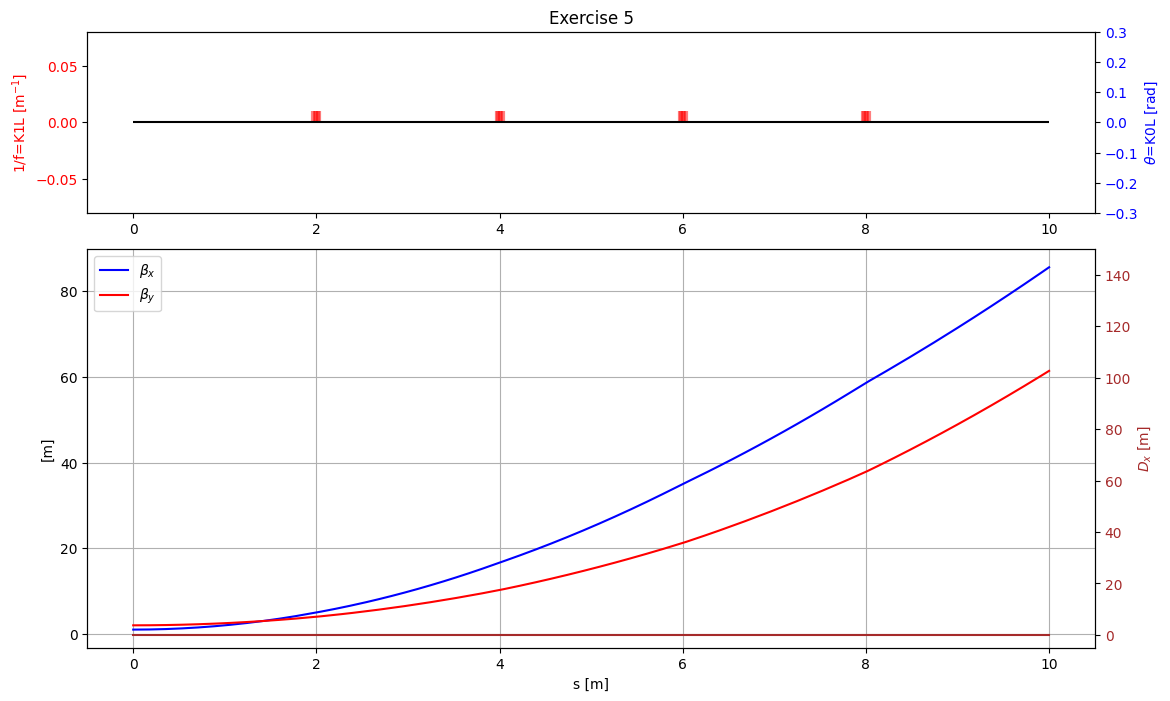

In [7]:
# %%
def plotLatticeSeries(ax,mys, length, height=1., v_offset=0., color='r',alpha=0.5,lw=3):

    ax.add_patch(
    patches.Rectangle(
        (mys, v_offset-height/2.),   # (x,y)
        length,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

def useful_plots(transfer_line, tw1, ylim1=None, ylim2=None, ylim3=None, filter_elements="ThinSliceQuadrupole"):
    fig = plt.figure(figsize=(13,8))

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.hlines(y=0,xmin=0,xmax=transfer_line.get_length(), color='black', linestyle='-')
    #plt.grid()
    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    if ylim1 is not None:
        plt.ylim(ylim1[0], ylim1[1])
    else:
        plt.ylim(-.08,.08)
    #plt.ylim(-2,2)


    plt.title('Exercise 5')
    quads_table = transfer_line.get_table().rows[transfer_line.get_table().element_type ==  filter_elements] #
    for quad in quads_table.name:
        k1l = transfer_line.get_strengths().rows[quad].k1l[0] * n_slices_quads
        aux = tw1.rows[quad].s[0]
        #print(quad, k1l) #transfer_line.get(quad)
        try:
            length = transfer_line.get(quad).length
        except:
            length=0
        plotLatticeSeries(plt.gca(),aux, length, height=k1l, v_offset=k1l/2, color='r')


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)
    if ylim2 is not None:
        plt.ylim(ylim2[0], ylim2[1])
    else:
        plt.ylim(-.3,.3)
    #plt.ylim(-.3,.3)

    for quad in quads_table.name:
        k0l = transfer_line.get_strengths().rows[quad].k0l[0] * n_slices_quads
        aux = tw1.rows[quad].s[0]
        #print(quad, k0l) #transfer_line.get(quad)
        try:
            length = transfer_line.get(quad).length
        except:
            length=0
        plotLatticeSeries(plt.gca(),aux, length, height=k0l, v_offset=k0l/2, color='b')

    ax3 = plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(tw1['s'], tw1['betx'], label= r'$\beta_x$', c="blue")
    plt.plot(tw1['s'], tw1['bety'], label=r'$\beta_y$', c="red")
    plt.legend()
    plt.grid()
    plt.ylabel("[m]")
    plt.xlabel("s [m]")

    ax4 = plt.gca().twinx()
    plt.plot(tw1['s'], tw1["dx"], c="brown")
    plt.ylabel(r"$D_x$ [m]", c="brown")
    plt.tick_params(axis='y', labelcolor='brown')
    if ylim3 is not None:
        plt.ylim(ylim3[0], ylim3[1])
    else:
        plt.ylim(-5, 150)
    return fig, ax1, ax2, ax3, ax4;

fig, ax1, ax2, ax3, ax4 = useful_plots(transfer_line, tw1, filter_elements=filter_elements)

In [8]:
print("betx end: ", tw1.rows["_end.*"]["betx"][0])
print("bety end: ", tw1.rows["_end.*"]["bety"][0])
print("alphax end: ", tw1.rows["_end.*"]["alfx"][0])
print("alphay end: ", tw1.rows["_end.*"]["alfy"][0])
initial_end_betx = tw1.rows["_end.*"]["betx"][0]
initial_end_bety = tw1.rows["_end.*"]["bety"][0]
initial_end_alfx = tw1.rows["_end.*"]["alfx"][0]
initial_end_alfy = tw1.rows["_end.*"]["alfy"][0]



betx end:  85.59886911702657
bety end:  61.41317155282872
alphax end:  -7.397806111511338
alphay end:  -6.624496852043111


In [9]:

transfer_line.vars.get_table()

Table: 9 rows, 3 cols
name               value expr
t_turn_s               0 None
ql                   0.1 None
cellLength            10 None
myk1                 0.1 None
myk2                 0.1 None
myk3                 0.1 None
myk4                 0.1 None
theta1                 0 None
theta2                 0 None

In [10]:
opt = transfer_line.match(
    start=tw1.name[0],
    end=tw1.name[-1],
    betx=1, bety=2,
    solve=False,
    method='4d',
    vary=xt.VaryList(['myk1', 'myk2', 'myk3', 'myk4'], step=1e-5),
    targets=xt.TargetSet(
        betx=2,
        bety=1,
        alfx=0,
        alfy=0,
        at=xt.END
    ))
#%%
print('Before match:')
opt.target_status()

opt.solve()

print('After match:')
opt.target_status()

print('\nMatch history')
opt.log()

Before match:el call n. 0               
Target status:                          
id state tag tol_met       residue   current_val target_val description                                 
0  ON          False       83.5989       85.5989          2 ('betx', '_end_point'), val=2, tol=1e-09 ...
1  ON          False       60.4132       61.4132          1 ('bety', '_end_point'), val=1, tol=1e-09 ...
2  ON          False      -7.39781      -7.39781          0 ('alfx', '_end_point'), val=0, tol=1e-09 ...
3  ON          False       -6.6245       -6.6245          0 ('alfy', '_end_point'), val=0, tol=1e-09 ...


/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/minif

Matching: model call n. 62               

After match:
Target status:                           
id state tag tol_met       residue   current_val target_val description                                 
0  ON           True   3.17191e-10             2          2 ('betx', '_end_point'), val=2, tol=1e-09 ...
1  ON           True   4.77036e-11             1          1 ('bety', '_end_point'), val=1, tol=1e-09 ...
2  ON           True  -2.99205e-11  -2.99205e-11          0 ('alfx', '_end_point'), val=0, tol=1e-09 ...
3  ON           True  -1.30475e-11  -1.30475e-11          0 ('alfy', '_end_point'), val=0, tol=1e-09 ...

Match history


Table: 9 rows, 18 cols
iteration                   penalty alpha tag tol_met target_active hit_limits vary_active ...
0                           143.177    -1     nnnn    yyyy          nnnn       yyyy       
1                           45.3282     4     nnnn    yyyy          nnnn       yyyy       
2                           11.9303     8     nnnn    yyyy          nnnn       yyyy       
3                           4.75573     1     nnnn    yyyy          nnnn       yyyy       
4                          0.851997     0     nnnn    yyyy          nnnn       yyyy       
5                          0.328301     0     nnnn    yyyy          nnnn       yyyy       
6                         0.0116595     0     nnnn    yyyy          nnnn       yyyy       
7                       2.75041e-05     0     nnnn    yyyy          nnnn       yyyy       
8                       4.57639e-10     0     yyyy    yyyy          nnnn       yyyy       

{'myk1': 0.1, 'myk2': 0.1, 'myk3': 0.1, 'myk4': 0.1}
{'myk1': -2.645907928453548, 'myk2': 5.926231627790418, 'myk3': -5.926231627585743, 'myk4': 2.6459079273275785}
1.0 2.0000000000000004 -0.0 -0.0
2.000000000317191 1.0000000000477036 -2.992054544590294e-11 -1.3047452008008511e-11


/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)


/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/minif

/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)
/Users/skostogl/Documents/python_Jul23/miniforge3/lib/python3.10/site-packages/xtrack/particles/particles.py:1358: RuntimeWarning: invalid value encountered in sqrt
  out = sqrt((1 + self.delta) ** 2 - self.kin_px ** 2 - self.kin_py ** 2)


Matching: model call n. 334               



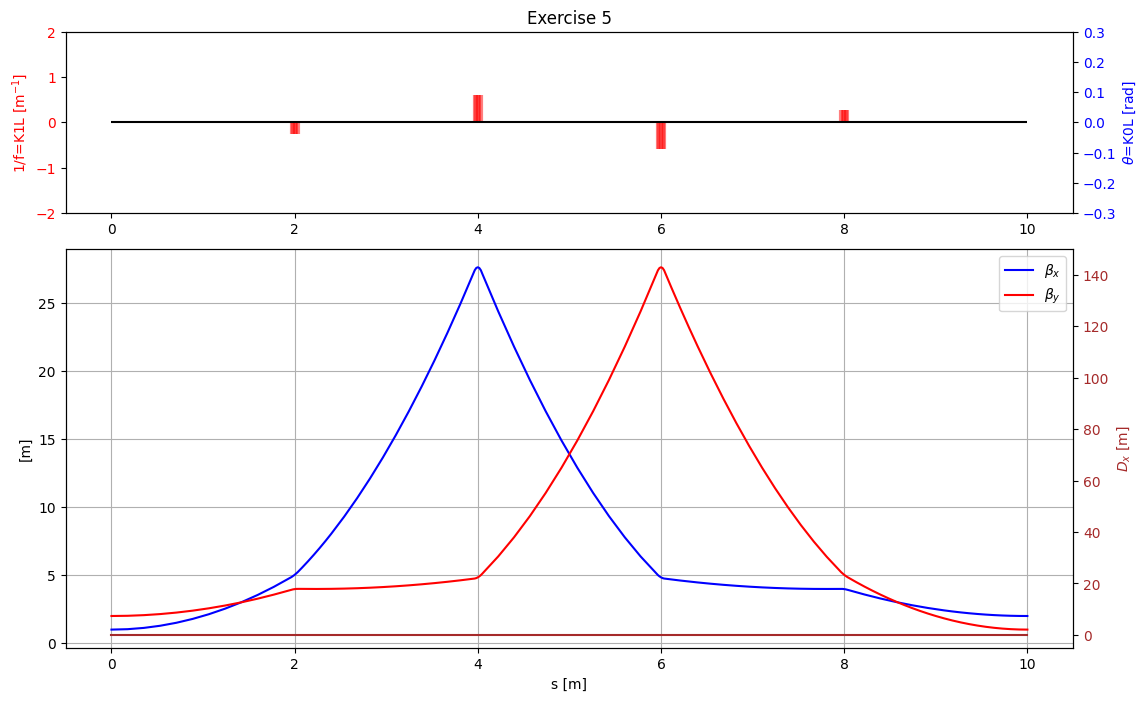

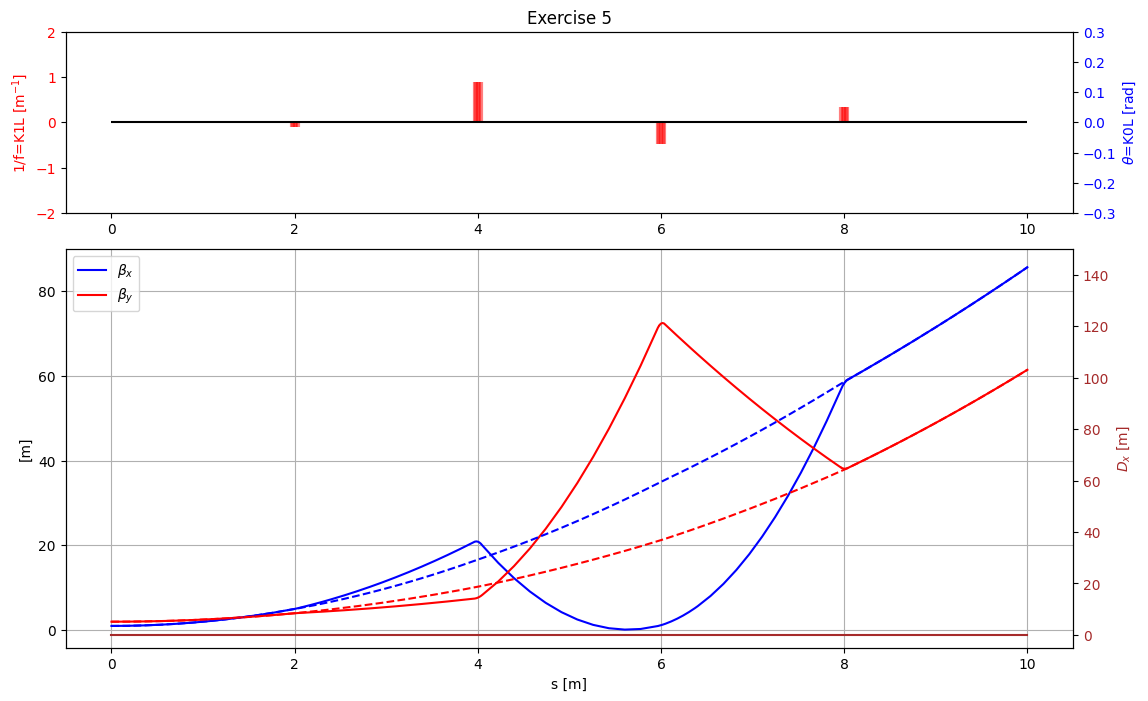

In [11]:

knobs_after_match = opt.get_knob_values()
knobs_before_match = opt.get_knob_values(iteration=0)
print(knobs_before_match)
print(knobs_after_match)
# %%
tw_after_matching = transfer_line.twiss(betx=1, bety=2)
print(tw_after_matching["betx"][0], tw_after_matching["bety"][0], tw_after_matching["alfx"][0], tw_after_matching["alfy"][0])
print(tw_after_matching["betx"][-1], tw_after_matching["bety"][-1], tw_after_matching["alfx"][-1], tw_after_matching["alfy"][-1])

# %%
fig, ax1, ax2, ax3, ax4 = useful_plots(transfer_line, tw_after_matching, ylim1=(-2,2), ylim2=(-.3,.3), ylim3=(-5, 150), filter_elements=filter_elements)
# %%

opt = transfer_line.match(
    start=tw1.name[0],
    end=tw1.name[-1],
    betx=1, bety=2,
    solve=True,
    method='4d',
    n_steps_max=500,
    vary=xt.VaryList(['myk1', 'myk2', 'myk3', 'myk4'], step=1e-5),
    targets=xt.TargetSet(
        betx=initial_end_betx,
        bety=initial_end_bety,
        alfx=initial_end_alfx,
        alfy=initial_end_alfy,
        at=xt.END
    ))

tw_after_matching2 = transfer_line.twiss(betx=1, bety=2)
fig, ax1, ax2, ax3, ax4 = useful_plots(transfer_line, tw_after_matching2, ylim1=(-2,2), ylim2=(-.3,.3), ylim3=(-5, 150), filter_elements=filter_elements)
plt.sca(ax3)
plt.plot(tw1.s, tw1.betx, label="Initial", c="b", linestyle='--')
plt.plot(tw1.s, tw1.bety, label="Initial", c="r", linestyle='--')

1.0 2.0000000000000004 -0.0 -0.0
85.5988691170236 61.41317155288099 -7.397806111510334 -6.624496852054335
#  vars['myk1']._get_value()
   vars['myk1'] = -1.1090094893158102

#  vars['myk1']._expr is None

#  vars['myk1']._find_dependant_targets()
   element_refs['q1'].k1

Matching: model call n. 43               



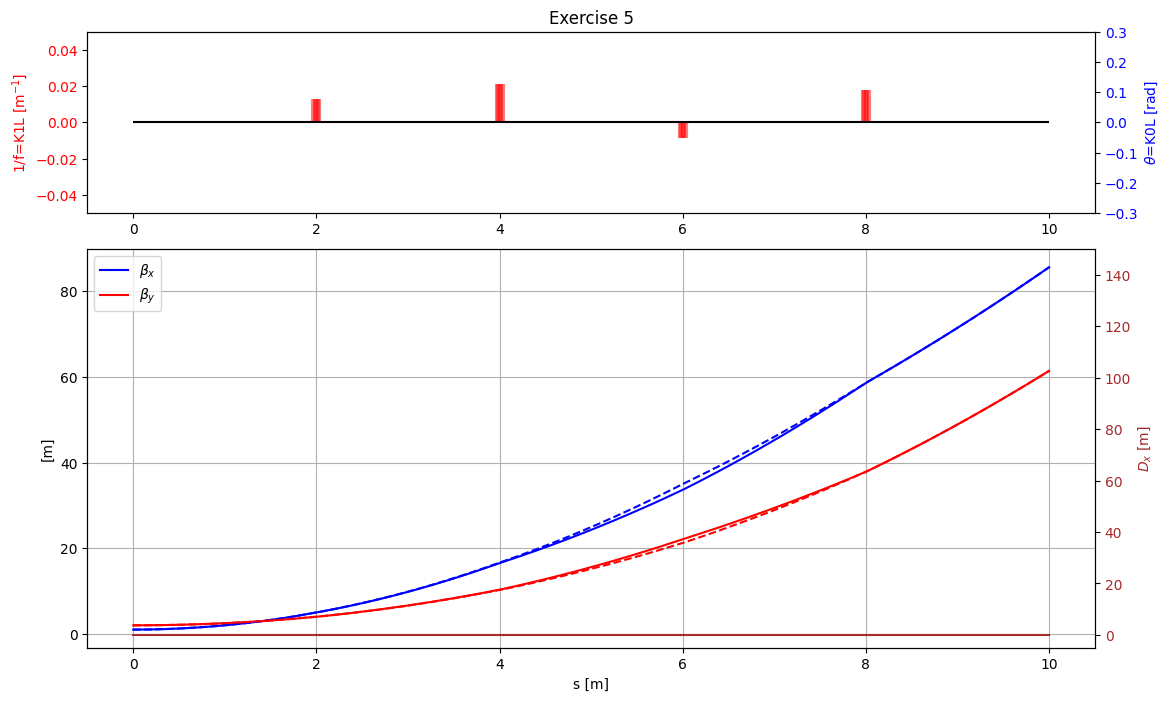

In [12]:

print(tw_after_matching2["betx"][0], tw_after_matching2["bety"][0], tw_after_matching2["alfx"][0], tw_after_matching2["alfy"][0])
print(tw_after_matching2["betx"][-1], tw_after_matching2["bety"][-1], tw_after_matching2["alfx"][-1], tw_after_matching2["alfy"][-1])

# %%
transfer_line.vars["myk1"]._info()


# %%
transfer_line.vars["myk1"] = 0.05
transfer_line.vars["myk2"] = 0.05
transfer_line.vars["myk3"] = 0.05
transfer_line.vars["myk4"] = 0.05


opt = transfer_line.match(
    start=tw1.name[0],
    end=tw1.name[-1],
    betx=1, bety=2,
    solve=True,
    method='4d',
    n_steps_max=500,
    vary=xt.VaryList(['myk1', 'myk2', 'myk3', 'myk4'], step=1e-5),
    targets=xt.TargetSet(
        betx=initial_end_betx,
        bety=initial_end_bety,
        alfx=initial_end_alfx,
        alfy=initial_end_alfy,
        at=xt.END
    ))

tw_after_matching3 = transfer_line.twiss(betx=1, bety=2)
fig, ax1, ax2, ax3, ax4 = useful_plots(transfer_line, tw_after_matching3, ylim1=(-0.05,0.05), ylim2=(-.3,.3), ylim3=(-5, 150), filter_elements=filter_elements)
plt.sca(ax3)
plt.plot(tw1.s, tw1.betx, label="Initial", c="b", linestyle='--')
plt.plot(tw1.s, tw1.bety, label="Initial", c="r", linestyle='--')

-7.3245995788161515 -0.89937483083823
-3.543560622077928 -0.9717754782387978


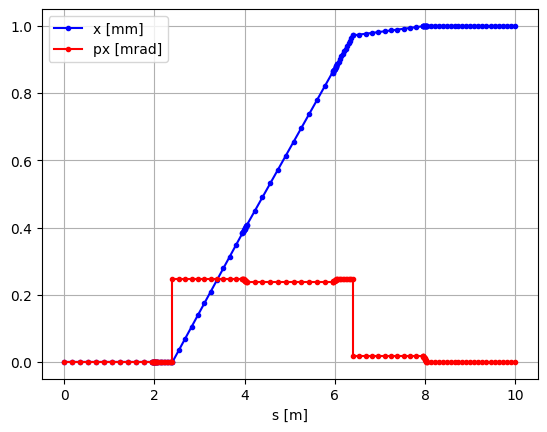

In [13]:




# %%
# Matrix response of the kickers
transfer_line.vars["theta1"] = 1e-6
transfer_line.vars["theta2"] = 0e-6

tw_kicker = transfer_line.twiss(betx=1, bety=2)
m11 = tw_kicker.x[-1]/1e-6
m21 = tw_kicker.px[-1]/1e-6
print(m11, m21)

transfer_line.vars["theta1"] = 0e-6
transfer_line.vars["theta2"] = 1e-6

tw_kicker = transfer_line.twiss(betx=1, bety=2)
m12 = tw_kicker.x[-1]/1e-6
m22 = tw_kicker.px[-1]/1e-6
print(m12, m22)

# %%
M_response=np.array([[m11, m12], [m21, m22]])
M_response
# %%

mySolution=np.linalg.inv(M_response)@np.array([[1e-3],[0]])
mySolution
# %%

transfer_line.vars["theta1"] = mySolution[0][0]
transfer_line.vars["theta2"] = mySolution[1][0]

aux= transfer_line.twiss(betx=1, bety=2)
aux["x"], aux["px"]

# %%
plt.plot(aux['s'],aux['x']*1000,'b.-',label='x [mm]')
plt.plot(aux['s'],aux['px']*1000,'r.-',label='px [mrad]')
plt.grid()
plt.xlabel('s [m]')
plt.legend(loc='best')
# %%
